GPLVM
--
This notebook shows how to build GPLVM model.

In [30]:
import GPflow
from GPflow import ekernels
from GPflow import kernels
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
%matplotlib inline
import pods
pods.datasets.overide_manual_authorize = True  # dont ask to authorize
GPflow.settings.numerics.quadrature = 'warn'

In [2]:
data = pods.datasets.oil_100()

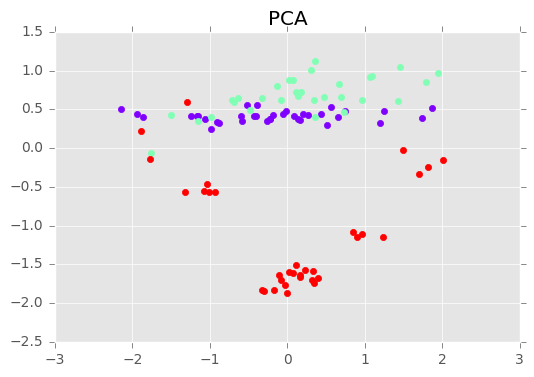

In [3]:
# import matplotlib.cm as cm
Y = data['X']
XPCA = GPflow.gplvm.PCA_reduce(data['X'], 2)
labels=data['Y'].argmax(axis=1)
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))
for i, c in zip(np.unique(labels), colors):
    plt.scatter(XPCA[labels==i,0], XPCA[labels==i,1], color=c, label=i)
plt.title('PCA')

### Model construction

Create Bayesian GPLVM model.

In [17]:
Q = 6
M = 10  # number of inducing pts
N = Y.shape[0]
X_mean = GPflow.gplvm.PCA_reduce(Y, Q) # Initialise via PCA
k = ekernels.Add([ekernels.RBF(3, ARD=True, active_dims=[0,1,2]),
                  ekernels.Linear(3, active_dims=[3,4,5])])
k.num_gauss_hermite_points = 0
# kernels.PeriodicKernel(1, active_dims=[1])])
Z = np.random.permutation(X_mean.copy())[:M]
m = GPflow.gplvm.BayesianGPLVM(X_mean=X_mean, X_var=np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

In [31]:
Q = 6
M = 10  # number of inducing pts
N = Y.shape[0]
X_mean = GPflow.gplvm.PCA_reduce(Y, Q) # Initialise via PCA
k = ekernels.Add([ekernels.RBF(5, ARD=True, active_dims=[0,1,2,3,4]),
                  kernels.PeriodicKernel(1, active_dims=[5])])
# 
Z = np.random.permutation(X_mean.copy())[:M]
m = GPflow.gplvm.BayesianGPLVM(X_mean=X_mean, X_var=np.ones((N, Q)), Y=Y,
                                kern=k, M=M, Z=Z)
m.likelihood.variance = 0.01

k.num_gauss_hermite_points = 20 # sum uses quadrature
k.kern_list[0].num_gauss_hermite_points = 0 # RBF does not
k.kern_list[1].num_gauss_hermite_points = 20 # periodic uses quad

m.optimize(disp=True)

/home/mqbssaby/python/GPflow/GPflow/kernels.py:159: UserWarning: Using numerical quadrature for kernel expectation. Use GPflow.ekernels instead.
  warnings.warn("Using numerical quadrature for kernel expectation. Use GPflow.ekernels instead.")
/home/mqbssaby/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


      fun: array([-159.23343839])
 hess_inv: <1270x1270 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.07196846e+00,   1.00798641e-12,  -1.67579675e-03, ...,
         1.07326062e-05,   3.76560957e-05,  -5.35664843e-02])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 1160
      nit: 1001
   status: 1
  success: False
        x: array([ -3.55948347, -37.83393837,   2.04266164, ...,   0.54129649,
         0.54143385,   0.43731423])

In [19]:
# Plot ARD weights to pick which dimensions to plot

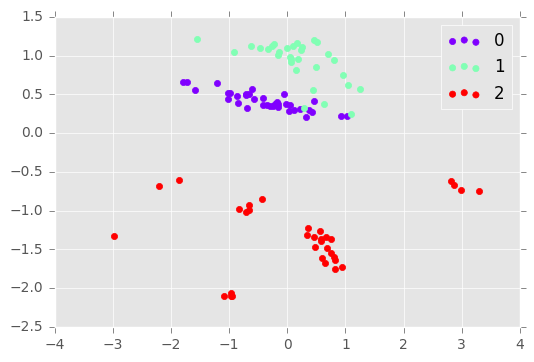

In [20]:
# plot
for i, c in zip(np.unique(labels), colors):
    plt.scatter(m.X_mean.value[labels==i,0], m.X_mean.value[labels==i,1], color=c, label=i)
plt.legend()

In [8]:
a=np.arange(6)
a

array([0, 1, 2, 3, 4, 5])

In [11]:
a[slice(0,3)]

array([0, 1, 2])

In [13]:
a[slice(3,6)]

array([3, 4, 5])